In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data Cleaning

In [ ]:
# Load batches of data to test code
# For most accurate results use all data
chunk_size = 100000
csv_chunks = pd.read_csv('US_Accidents_March23.csv', chunksize=chunk_size)

# Load in batches of data one by one
all_chunks = [] 
for i, chunk in enumerate(csv_chunks):
    # Only keep necessary columns, we focus on weather
    cols_to_keep = ['Severity', 'Temperature(F)', 'Wind_Chill(F)', 
                    'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 
                    'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition']
    df = chunk[cols_to_keep]
    
    # fill na with 0 so we don't lose info or unintentionally condition our data on bad weather
    df = df.fillna(0)
    all_chunks.append(df)

    # limit number of chunks
    if i == 5:
        break
# Combine chunks into one dataframe
df = pd.concat(all_chunks)

In [ ]:
#df = pd.read_csv('cleaned_US_Accidents.csv/cleaned_US_Accidents.csv', index_col=0)
# Load all data for most accurate results
df = pd.read_csv('cleaned_US_Accidents.csv', index_col=0)

# Only keep necessary columns, we focus on weather
cols_to_keep = ['Severity', 'Temperature(F)', 'Wind_Chill(F)', 
                'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 
                'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition']
df = df[cols_to_keep]

# fill na with 0 so we don't lose info or unintentionally condition our data on bad weather
df = df.fillna(0)
data = pd.get_dummies(df, drop_first=True, dtype=np.int64)

# Separate the dependant and independant variable
# We predict the severity based on the weather
X = data.drop(columns=['Severity'])
y = data['Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# Random Forest

In [ ]:
# Initialize and fit the forest
rf = RandomForestClassifier(oob_score=True)
rf.fit(X_train, y_train)

print(f'Oob Score: {rf.oob_score_}')

# Extract the feature importances of the forest
feature_importances = rf.feature_importances_
feature_names = X.columns
features = sorted(zip(feature_importances, feature_names))
print(f'Best Features {features[-3:]}')
print(f'Worst Features {features[:3]}')

0.7433923690105174
Best Features [(np.float64(0.16361551234289745), 'Temperature(F)'), (np.float64(0.221092650963089), 'Humidity(%)'), (np.float64(0.2739646261215936), 'Pressure(in)')]
Worst Features [(np.float64(0.0007790038234628381), 'Wind_Direction_Variable'), (np.float64(0.00139021417949821), 'Wind_Direction_VAR'), (np.float64(0.0014927252954159845), 'Wind_Direction_East')]


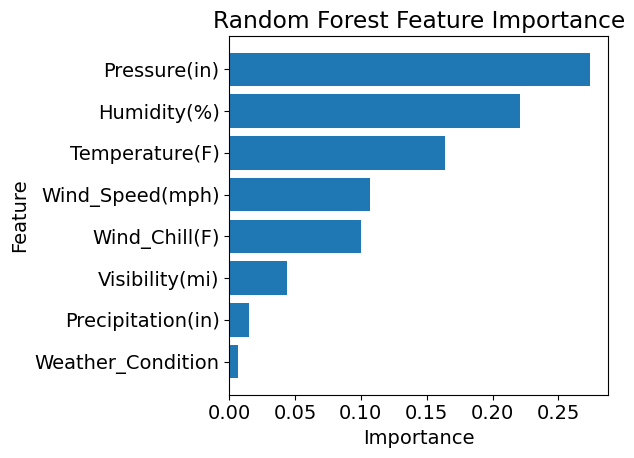

In [ ]:
# Only plot the most important features to avoid overcrowding
importances = rf.feature_importances_
k = len(importances) // 4
indices = np.argsort(importances)[-k:]

# Plot and label importances
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), feature_names[indices])
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('figures/rf_feature_importance')

In [ ]:
# Decide what values of max_depth and max_features to search over
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
max_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
best_oob_score = 0
best_params = None

# Perform a grid search
for max_depth in max_depths:
  for mf in max_features:
    # Initialize and fit the forest
    rf = RandomForestClassifier(oob_score=True, max_depth=max_depth, max_features=mf)
    rf.fit(X_train, y_train)
      
    # find best oob score and save parameters
    if best_oob_score < rf.oob_score_:
      best_oob_score = rf.oob_score_
      best_params = max_depth, mf

print(f'Best Oob Score: {best_oob_score}')
print(f'Best Parameters: {best_params}')

# Boosting

In [ ]:
# Initialize and fit the forest
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# Identify and print accuracy
y_pred = gb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

0.7628015551608767


In [ ]:
# Extract the feature importances of the forest
feature_importances = gb.feature_importances_
feature_names = X.columns

# Print best and worst features
features = sorted(zip(feature_importances, feature_names))
print(f'Best Features: {features[-3:]}')
print(f'Worst Features: {features[:3]}')

Best Features [(np.float64(0.049451666201821676), 'Wind_Speed(mph)'), (np.float64(0.28625981976462767), 'Pressure(in)'), (np.float64(0.51703219701833), 'Wind_Chill(F)')]
Worst Features [(np.float64(0.0), 'Wind_Direction_ENE'), (np.float64(3.1607864413012233e-06), 'Wind_Direction_ESE'), (np.float64(2.4272454297274127e-05), 'Wind_Direction_NW')]


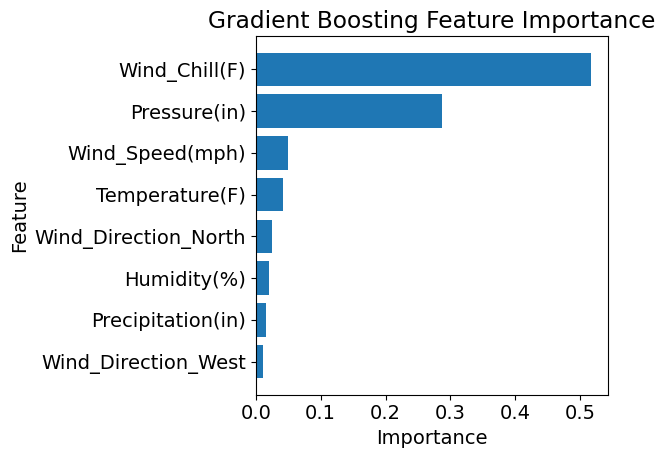

In [ ]:
# Only plot the highests importances to avoid overcrowding
importances = gb.feature_importances_
k = len(importances) // 4
indices = np.argsort(importances)[-k:]

# Plot and label XG-boost importances
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), feature_names[indices])
plt.title('Gradient Boosting Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("figures/boosting_feature_importance")